## Installing Required Libraries

## Importing required Libraries

In [1]:
import pandas as pd
import numpy as np
import json
import re
from typing import List, Dict, Any, Tuple
from openai import OpenAI
import time
from dotenv import load_dotenv
import openai
import os
from datasets import load_dataset
import chromadb
from datetime import datetime, timedelta
import random
import sqlite3


# ✅ Load environment variables
load_dotenv()
openai_api_key = os.getenv("OPEN_AI_KEY")
phoenix_endpoint = os.getenv("PHOENIX_COLLECTOR_ENDPOINT")


/Users/vijendra/multi-agent-system/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setting up Prompt Monitoring

In [2]:
from functools import wraps
import time
from opentelemetry.trace.status import Status, StatusCode
from opentelemetry.trace import get_current_span
from phoenix.otel import register

tracer_provider = register(
    project_name="multi-agent-system",
    endpoint=phoenix_endpoint,
    auto_instrument=True
)
tracer = tracer_provider.get_tracer(__name__)



# --- Decorator ---
def trace_agent(func):
    """
    Decorator to wrap multi-agent functions in a Phoenix span with metadata.
    """
    @wraps(func)
    def wrapper(*args, **kwargs):
        state = args[0] if args else {}
        agent_name = func.__name__

        with tracer.start_as_current_span(agent_name) as span:
            # --- Add standard metadata ---
            span.set_attribute("agent.name", agent_name)
            span.set_attribute("agent.type", agent_name.replace("_node", ""))
            span.set_attribute("user.id", state.get("customer_id", "unknown"))
            span.set_attribute("policy.number", state.get("policy_number", "unknown"))
            span.set_attribute("claim.id", state.get("claim_id", "unknown"))
            span.set_attribute("task", state.get("task", "none"))
            span.set_attribute("timestamp", state.get("timestamp", "n/a"))

            start_time = time.time()

            try:
                result = func(*args, **kwargs)

                # --- Record execution metadata ---
                duration = time.time() - start_time
                span.set_attribute("execution.duration_sec", duration)
                if isinstance(result, dict):
                    span.set_attribute("result.keys", list(result.keys()))
                span.set_status(Status(StatusCode.OK))
                return result

            except Exception as e:
                span.record_exception(e)
                span.set_status(Status(StatusCode.ERROR, str(e)))
                raise

    return wrapper

🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: multi-agent-system
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: http://127.0.0.1:6006/v1/traces
|  Transport: HTTP + protobuf
|  Transport Headers: {}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  ⚠️ WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



## Data Infrastructure

### Setting up the FAQ Data

In [3]:
from datasets import load_dataset
import pandas as pd

# Load the dataset from Hugging Face
ds = load_dataset("deccan-ai/insuranceQA-v2")

# Combine all splits into a single DataFrame
df = pd.concat([split.to_pandas() for split in ds.values()], ignore_index=True)
df["combined"] = "Question: " + df["input"] + " \n Answer:  " + df["output"]
# Inspect
print(df.shape)
df.head()


(27987, 3)


,input,output,combined
0,What Does Medicare IME Stand For?,According to the Centers for Medicare and Medi...,Question: What Does Medicare IME Stand For? \...
1,Is Long Term Care Insurance Tax Free?,"As a rule , if you buy a tax qualified long te...",Question: Is Long Term Care Insurance Tax Free...
2,Can Husband Drop Wife From Health Insurance?,Can a spouse drop another spouse from health i...,Question: Can Husband Drop Wife From Health In...
3,Is Medicare Run By The Government?,Medicare Part A and Part B is provided by the ...,Question: Is Medicare Run By The Government? ...
4,Is Medicare Run By The Government?,Definitely . It is ran by the Center for Medic...,Question: Is Medicare Run By The Government? ...


In [4]:
import chromadb
# Setting up the Chromadb
chroma_client = chromadb.PersistentClient(path="./chroma_db")
# Create or get the collection
collection = chroma_client.get_or_create_collection(name="insurance_FAQ_collection")


In [5]:
# Collection 1 for insurance Q&A Dataset
from tqdm import tqdm
df = df.sample(500, random_state=42).reset_index(drop=True)  # For testing, use a smaller subset
# Add data to collection
# here the chroma db will use default embeddings (sentence transformers)
# Split into batches of <= 5000
batch_size = 100

for i in tqdm(range(0, len(df), batch_size)):
    batch_df = df.iloc[i:i+batch_size]
    collection.add(
        documents=batch_df["combined"].tolist(),
        metadatas=[{"question": q, "answer": a} for q, a in zip(batch_df["input"], batch_df["output"])],
        ids=batch_df.index.astype(str).tolist()
    )

100%|██████████| 5/5 [00:18<00:00,  3.66s/it]


In [6]:
## Testing the retrieval
query = "What does life insurance cover?"
collection = chroma_client.get_collection(name="insurance_FAQ_collection")
results = collection.query(
    query_texts=[query],
    n_results=3,
)

for i, m in enumerate(results["metadatas"][0]):
    print(f"Result {i+1}:")
    print("Distance:", results["distances"][0][i])
    print("Q:", m["question"])
    print("A:", m["answer"])
    print("-" * 50)


Result 1:
Distance: 0.3581928610801697
Q: What Does Life Insurance Typically Cover? 
A: Life insurance is intended to provide some monetary assistance in the event that the insured passes away while covered . Life insurance is typically meant as a way for the family of the insured to be financially capable of moving on after the loss . The funds from the policy are intended to help provide for those things that could have possibly been provided -LRB- i.e. pay off debt , pay for college , etc. . . -RRB- by the insured if the insured had not passed . This is a very limited explanation of life insurance , contact a local agent to discuss your wants and needs with this type of coverage . 
--------------------------------------------------
Result 2:
Distance: 0.41367289423942566
Q: What Does Life Insurance Typically Cover? 
A: Life insurance is designed to pay a determined benefit amount upon the death of the insured . Any cause of death is typically covered except suicide within the first 

### Generating Synthetic Data

In [7]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

def generate_sample_data(random_state=42):
    """Generate enriched sample data for all tables with 50 first/last names"""
    random.seed(random_state)
    np.random.seed(random_state)
    # Define 50 first and last names
    first_names = [
        "John", "Jane", "Robert", "Maria", "David", "Lisa", "Michael", "Sarah", "James", "Emily",
        "William", "Emma", "Joseph", "Olivia", "Charles", "Ava", "Thomas", "Isabella", "Daniel", "Mia",
        "Matthew", "Sophia", "Anthony", "Charlotte", "Christopher", "Amelia", "Andrew", "Harper",
        "Joshua", "Evelyn", "Ryan", "Abigail", "Brandon", "Ella", "Justin", "Scarlett", "Tyler", "Grace",
        "Alexander", "Chloe", "Kevin", "Victoria", "Jason", "Lily", "Brian", "Hannah", "Eric", "Aria",
        "Kyle", "Zoey"
    ]

    last_names = [
        "Smith", "Johnson", "Williams", "Brown", "Jones", "Garcia", "Miller", "Davis", "Rodriguez", "Martinez",
        "Hernandez", "Lopez", "Gonzalez", "Wilson", "Anderson", "Thomas", "Taylor", "Moore", "Jackson", "Martin",
        "Lee", "Perez", "Thompson", "White", "Harris", "Sanchez", "Clark", "Ramirez", "Lewis", "Robinson",
        "Walker", "Young", "Allen", "King", "Wright", "Scott", "Torres", "Nguyen", "Hill", "Flores",
        "Green", "Adams", "Nelson", "Baker", "Hall", "Rivera", "Campbell", "Mitchell", "Carter", "Roberts"
    ]

    # Generate customers (1000 random name combinations)
    customers = pd.DataFrame({
        'customer_id': [f'CUST{str(i).zfill(5)}' for i in range(1, 1001)],
        'first_name': [random.choice(first_names) for _ in range(1000)],
        'last_name': [random.choice(last_names) for _ in range(1000)],
        'email': [f'user{i}@example.com' for i in range(1, 1001)],
        'phone': [f'555-{str(random.randint(100,999)).zfill(3)}-{str(random.randint(1000,9999)).zfill(4)}' for _ in range(1000)],
        'date_of_birth': [datetime(1980, 1, 1) + timedelta(days=random.randint(0, 10000)) for _ in range(1000)],
        'state': [random.choice(['CA', 'NY', 'TX', 'FL', 'IL', 'PA', 'OH', 'GA']) for _ in range(1000)]
    })

    # Policies
    policies = pd.DataFrame({
        'policy_number': [f'POL{str(i).zfill(6)}' for i in range(1, 1501)],
        'customer_id': [f'CUST{str(random.randint(1, 1000)).zfill(5)}' for _ in range(1500)],
        'policy_type': [random.choice(['auto', 'home', 'life']) for _ in range(1500)],
        'start_date': [datetime(2023, 1, 1) + timedelta(days=random.randint(0, 365)) for _ in range(1500)],
        'premium_amount': [round(random.uniform(50, 500), 2) for _ in range(1500)],
        'billing_frequency': [random.choice(['monthly', 'quarterly', 'annual']) for _ in range(1500)],
        'status': [random.choice(['active', 'active', 'active', 'cancelled']) for _ in range(1500)]
    })

    # Auto Policy Details (subset)
    auto_policies = policies[policies['policy_type'] == 'auto'].copy()
    auto_policy_details = pd.DataFrame({
        'policy_number': auto_policies['policy_number'],
        'vehicle_vin': [f'VIN{random.randint(10000000000000000, 99999999999999999)}' for _ in range(len(auto_policies))],
        'vehicle_make': [random.choice(['Toyota', 'Honda', 'Ford', 'Chevrolet', 'Nissan']) for _ in range(len(auto_policies))],
        'vehicle_model': [random.choice(['Camry', 'Civic', 'F-150', 'Malibu', 'Altima']) for _ in range(len(auto_policies))],
        'vehicle_year': [random.randint(2015, 2023) for _ in range(len(auto_policies))],
        'liability_limit': [random.choice([50000, 100000, 300000]) for _ in range(len(auto_policies))],
        'collision_deductible': [random.choice([250, 500, 1000]) for _ in range(len(auto_policies))],
        'comprehensive_deductible': [random.choice([250, 500, 1000]) for _ in range(len(auto_policies))],
        'uninsured_motorist': [random.choice([0, 1]) for _ in range(len(auto_policies))],
        'rental_car_coverage': [random.choice([0, 1]) for _ in range(len(auto_policies))]
    })


    # Billing
    billing = pd.DataFrame({
        'bill_id': [f'BILL{str(i).zfill(6)}' for i in range(1, 5001)],
        'policy_number': [random.choice(policies['policy_number']) for _ in range(5000)],
        'billing_date': [datetime(2024, 1, 1) + timedelta(days=random.randint(0, 90)) for _ in range(5000)],
        'due_date': [datetime(2024, 1, 15) + timedelta(days=random.randint(0, 90)) for _ in range(5000)],
        'amount_due': [round(random.uniform(100, 1000), 2) for _ in range(5000)],
        'status': [random.choice(['paid', 'pending', 'overdue']) for _ in range(5000)]
    })

    # Payments
    payments = pd.DataFrame({
        'payment_id': [f'PAY{str(i).zfill(6)}' for i in range(1, 4001)],
        'bill_id': [random.choice(billing['bill_id']) for _ in range(4000)],
        'payment_date': [datetime(2024, 1, 1) + timedelta(days=random.randint(0, 90)) for _ in range(4000)],
        'amount': [round(random.uniform(50, 500), 2) for _ in range(4000)],
        'payment_method': [random.choice(['credit_card', 'debit_card', 'bank_transfer']) for _ in range(4000)],
        'transaction_id': [f'TXN{random.randint(100000,999999)}' for _ in range(4000)],
        'status': [random.choice(['completed', 'pending', 'failed']) for _ in range(4000)]
    })

    # Claims
    claims = pd.DataFrame({
        'claim_id': [f'CLM{str(i).zfill(6)}' for i in range(1, 301)],
        'policy_number': [random.choice(policies['policy_number']) for _ in range(300)],
        'claim_date': [datetime(2024, 1, 1) + timedelta(days=random.randint(0, 90)) for _ in range(300)],
        'incident_type': [random.choice(['collision', 'theft', 'property_damage', 'medical', 'liability']) for _ in range(300)],
        'estimated_loss': [round(random.uniform(500, 20000), 2) for _ in range(300)],
        'status': [random.choice(['submitted', 'under_review', 'approved', 'paid', 'denied']) for _ in range(300)]
    })



    return {
        'customers': customers,
        'policies': policies,
        'auto_policy_details': auto_policy_details,
        'billing': billing,
        'payments': payments,
        'claims': claims,
    }


sample_data = generate_sample_data()

In [8]:
print("Customers Data Shape:", sample_data["customers"].shape)
sample_data["customers"].head()

Customers Data Shape: (1000, 7)


,customer_id,first_name,last_name,email,phone,date_of_birth,state
0,CUST00001,Kevin,Lopez,user1@example.com,555-635-3600,2000-10-22,TX
1,CUST00002,Sarah,Martin,user2@example.com,555-472-7108,1996-07-08,TX
2,CUST00003,Jane,Smith,user3@example.com,555-389-7347,2006-07-17,NY
3,CUST00004,Aria,Rivera,user4@example.com,555-518-6543,2002-02-17,OH
4,CUST00005,Isabella,Wright,user5@example.com,555-795-1857,1988-10-06,PA


In [9]:
print("billing Data Shape:", sample_data["billing"].shape)
sample_data["billing"].head()

billing Data Shape: (5000, 6)


,bill_id,policy_number,billing_date,due_date,amount_due,status
0,BILL000001,POL000622,2024-02-13,2024-03-28,920.28,pending
1,BILL000002,POL000583,2024-03-30,2024-03-25,110.28,paid
2,BILL000003,POL001065,2024-03-08,2024-02-27,101.46,paid
3,BILL000004,POL001075,2024-03-04,2024-02-15,533.51,pending
4,BILL000005,POL001264,2024-01-27,2024-02-03,799.94,pending


In [10]:
print("payments Data Shape:", sample_data["payments"].shape)
sample_data["payments"].head()

payments Data Shape: (4000, 7)


,payment_id,bill_id,payment_date,amount,payment_method,transaction_id,status
0,PAY000001,BILL001071,2024-01-23,101.20,credit_card,TXN796819,failed
1,PAY000002,BILL002273,2024-02-04,331.82,bank_transfer,TXN105554,pending
2,PAY000003,BILL002829,2024-02-24,467.04,bank_transfer,TXN925464,failed
3,PAY000004,BILL004772,2024-01-28,119.61,bank_transfer,TXN331820,completed
4,PAY000005,BILL002404,2024-02-21,126.06,credit_card,TXN982141,pending


In [11]:
print("claims Data Shape:", sample_data["claims"].shape)
sample_data["claims"].head()

claims Data Shape: (300, 6)


,claim_id,policy_number,claim_date,incident_type,estimated_loss,status
0,CLM000001,POL000390,2024-01-04,medical,4212.29,approved
1,CLM000002,POL001125,2024-01-06,liability,7698.96,denied
2,CLM000003,POL000324,2024-03-25,theft,4513.04,paid
3,CLM000004,POL001059,2024-03-22,medical,16624.30,approved
4,CLM000005,POL001401,2024-02-14,theft,5361.10,under_review


In [12]:
print("policies Data Shape:", sample_data["policies"].shape)
sample_data["policies"].head()

policies Data Shape: (1500, 7)


,policy_number,customer_id,policy_type,start_date,premium_amount,billing_frequency,status
0,POL000001,CUST00023,home,2023-02-02,304.74,monthly,active
1,POL000002,CUST00791,home,2023-07-28,201.05,monthly,cancelled
2,POL000003,CUST00842,home,2023-07-06,184.83,monthly,cancelled
3,POL000004,CUST00966,auto,2023-12-10,197.88,monthly,active
4,POL000005,CUST00707,life,2023-12-03,97.18,monthly,active


In [13]:
print("auto policies Data Shape:", sample_data["auto_policy_details"].shape)
sample_data["auto_policy_details"].head()

auto policies Data Shape: (505, 10)


,policy_number,vehicle_vin,vehicle_make,vehicle_model,vehicle_year,liability_limit,collision_deductible,comprehensive_deductible,uninsured_motorist,rental_car_coverage
3,POL000004,VIN50109497631126418,Chevrolet,Malibu,2021,300000,500,1000,1,0
8,POL000009,VIN61377275813940714,Chevrolet,Camry,2018,100000,1000,1000,0,1
9,POL000010,VIN76195236404115382,Honda,Malibu,2017,100000,1000,250,0,1
13,POL000014,VIN85533411374448706,Ford,Altima,2023,100000,1000,500,0,0
16,POL000017,VIN42911775605991276,Honda,F-150,2015,300000,500,1000,0,0


### Uploading the Data to SQLite DB

In [14]:
import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import json


def connect_db(db_path='insurance_support.db'):
    """Connect to SQLite database"""
    return sqlite3.connect(db_path)


def drop_and_create_tables(conn):
    """Drop existing tables and recreate the schema"""
    cursor = conn.cursor()

    # Drop tables if exist
    cursor.executescript("""
        DROP TABLE IF EXISTS claims;
        DROP TABLE IF EXISTS payments;
        DROP TABLE IF EXISTS billing;
        DROP TABLE IF EXISTS auto_policy_details;
        DROP TABLE IF EXISTS policies;
        DROP TABLE IF EXISTS customers;
    """)

    # Create tables
    cursor.executescript("""
        CREATE TABLE customers (
            customer_id VARCHAR(20) PRIMARY KEY,
            first_name VARCHAR(50),
            last_name VARCHAR(50),
            email VARCHAR(100),
            phone VARCHAR(20),
            date_of_birth DATE,
            state VARCHAR(20)
        );

        CREATE TABLE policies (
            policy_number VARCHAR(20) PRIMARY KEY,
            customer_id VARCHAR(20),
            policy_type VARCHAR(50),
            start_date DATE,
            premium_amount DECIMAL(10,2),
            billing_frequency VARCHAR(20),
            status VARCHAR(20),
            FOREIGN KEY (customer_id) REFERENCES customers(customer_id)
        );

        CREATE TABLE auto_policy_details (
            policy_number VARCHAR(20) PRIMARY KEY,
            vehicle_vin VARCHAR(50),
            vehicle_make VARCHAR(50),
            vehicle_model VARCHAR(50),
            vehicle_year INTEGER,
            liability_limit DECIMAL(10,2),
            collision_deductible DECIMAL(10,2),
            comprehensive_deductible DECIMAL(10,2),
            uninsured_motorist BOOLEAN,
            rental_car_coverage BOOLEAN,
            FOREIGN KEY (policy_number) REFERENCES policies(policy_number)
        );

        CREATE TABLE billing (
            bill_id VARCHAR(20) PRIMARY KEY,
            policy_number VARCHAR(20),
            billing_date DATE,
            due_date DATE,
            amount_due DECIMAL(10,2),
            status VARCHAR(20),
            FOREIGN KEY (policy_number) REFERENCES policies(policy_number)
        );

        CREATE TABLE payments (
            payment_id VARCHAR(20) PRIMARY KEY,
            bill_id VARCHAR(20),
            payment_date DATE,
            amount DECIMAL(10,2),
            payment_method VARCHAR(50),
            transaction_id VARCHAR(100),
            status VARCHAR(20),
            FOREIGN KEY (bill_id) REFERENCES billing(bill_id)
        );

        CREATE TABLE claims (
            claim_id VARCHAR(20) PRIMARY KEY,
            policy_number VARCHAR(20),
            claim_date DATE,
            incident_type VARCHAR(100),
            estimated_loss DECIMAL(10,2),
            status VARCHAR(20),
            FOREIGN KEY (policy_number) REFERENCES policies(policy_number)
        );

    """)

    conn.commit()

def insert_data(conn, data):
    """Insert all DataFrames into SQLite"""
    for table, df in data.items():
        df.to_sql(table, conn, if_exists='append', index=False)
    conn.commit()


def setup_insurance_database(data):
    """Main function to create and populate the insurance database"""
    conn = connect_db()
    drop_and_create_tables(conn)
    insert_data(conn, data)
    conn.close()
    print("✅ Database created successfully with enriched synthetic data!")



setup_insurance_database(sample_data)

✅ Database created successfully with enriched synthetic data!


In [15]:
# test the SQL connection
conn = connect_db()
query = "SELECT * FROM customers LIMIT 5;"
df_sql = pd.read_sql_query(query, conn)
conn.close()
df_sql

,customer_id,first_name,last_name,email,phone,date_of_birth,state
0,CUST00001,Kevin,Lopez,user1@example.com,555-635-3600,2000-10-22 00:00:00,TX
1,CUST00002,Sarah,Martin,user2@example.com,555-472-7108,1996-07-08 00:00:00,TX
2,CUST00003,Jane,Smith,user3@example.com,555-389-7347,2006-07-17 00:00:00,NY
3,CUST00004,Aria,Rivera,user4@example.com,555-518-6543,2002-02-17 00:00:00,OH
4,CUST00005,Isabella,Wright,user5@example.com,555-795-1857,1988-10-06 00:00:00,PA


### Setting up Open AI Client

In [ ]:
from openai import OpenAI
import json
from typing import List, Dict, Any, Optional

client = OpenAI(api_key=openai_api_key)

def run_llm(
    prompt: str,
    tools: Optional[List[Dict]] = None,
    tool_functions: Optional[Dict[str, Any]] = None,
    model: str = "gpt-5-mini",
) -> str:
    """
    Run an LLM request that optionally supports tools.
    
    Args:
        prompt (str): The system or user prompt to send.
        tools (list[dict], optional): Tool schema list for model function calling.
        tool_functions (dict[str, callable], optional): Mapping of tool names to Python functions.
        model (str): Model name to use (default: gpt-5-mini).

    Returns:
        str: Final LLM response text.
    """

    # Step 1: Initial LLM call
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "system", "content": prompt}],
        tools=tools if tools else None,
        tool_choice="auto" if tools else None
    )

    message = response.choices[0].message
    print("Initial LLM Response:", message)

    # Step 2: If no tools or no tool calls, return simple model response
    if not getattr(message, "tool_calls", None):
        return message.content

    # Step 3: Handle tool calls dynamically
    if not tool_functions:
        return message.content + "\n\n⚠️ No tool functions provided to execute tool calls."

    tool_messages = []
    for tool_call in message.tool_calls:
        func_name = tool_call.function.name
        args = json.loads(tool_call.function.arguments or "{}")
        tool_fn = tool_functions.get(func_name)

        try:
            result = tool_fn(**args) if tool_fn else {"error": f"Tool '{func_name}' not implemented."}
        except Exception as e:
            result = {"error": str(e)}

        tool_messages.append({
            "role": "tool",
            "tool_call_id": tool_call.id,
            "content": json.dumps(result)
        })

    # Step 4: Second pass — send tool outputs back to the model
    followup_messages = [
        {"role": "system", "content": prompt},
        {
            "role": "assistant",
            "content": message.content,
            "tool_calls": [
                {
                    "id": tc.id,
                    "type": tc.type,
                    "function": {
                        "name": tc.function.name,
                        "arguments": tc.function.arguments,
                    },
                } for tc in message.tool_calls
            ],
        },
        *tool_messages,
    ]

    final = client.chat.completions.create(model=model, messages=followup_messages)
    return final.choices[0].message.content

In [17]:
prompt = "Explain the theory of relativity in simple terms in 30 words."
response = run_llm(prompt)
print(response)

Initial LLM Response: ChatCompletionMessage(content='Relativity: space and time form a single fabric that bends around mass, causing gravity. Motion affects time and length; light speed is constant, linking energy, mass, space, and time. Together.', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None)
Relativity: space and time form a single fabric that bends around mass, causing gravity. Motion affects time and length; light speed is constant, linking energy, mass, space, and time. Together.


In [18]:
def add_numbers(a: int, b: int):
    return {"result": a + b}

tools = [{
    "type": "function",
    "function": {
        "name": "add_numbers",
        "description": "Add two numbers together",
        "parameters": {
            "type": "object",
            "properties": {
                "a": {"type": "integer"},
                "b": {"type": "integer"}
            },
            "required": ["a", "b"]
        },
    }
}]

prompt = "Please add 3 and 5 using the available tool."
response = run_llm(prompt, tools=tools, tool_functions={"add_numbers": add_numbers})
print(response)

Initial LLM Response: ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageFunctionToolCall(id='call_FDVbCT2AnQjanu9U5Te3U3cv', function=Function(arguments='{"a":3,"b":5}', name='add_numbers'), type='function')])
3 + 5 = 8.


In [19]:
prompt = "Explain the theory of relativity in simple terms in 30 words."
response = run_llm(prompt, tools=tools, tool_functions={"add_numbers": add_numbers})
print(response)

Initial LLM Response: ChatCompletionMessage(content='The theory of relativity: space and time are linked; motion affects measurements, speed of light is constant, energy and mass are interchangeable, gravity curves spacetime, affecting clocks, distances, and motion.', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None)
The theory of relativity: space and time are linked; motion affects measurements, speed of light is constant, energy and mass are interchangeable, gravity curves spacetime, affecting clocks, distances, and motion.


### Defining the Tools

In [ ]:
# =====================================================
#  Define the TOOL functions (these run locally)
# =====================================================

import logging
from datetime import datetime

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('insurance_agent.log'),
        logging.StreamHandler()
    ]
)

logger = logging.getLogger(__name__)

def ask_user(question: str, missing_info: str = ""):
    """Ask the user for input and return the response."""
    logger.info(f"🗣️ Asking user for input: {question}")
    if missing_info:
        print(f"---USER INPUT REQUIRED---\nMissing information: {missing_info}")
    else:
        print(f"---USER INPUT REQUIRED---")
    
    answer = input(f"{question}: ")
    return {"context": answer, "source": "User Input"}

def get_policy_details(policy_number: str) -> Dict[str, Any]:
    """Fetch a customer's policy details by policy number"""
    logger.info(f"🔍 Fetching policy details for: {policy_number}")
    conn = sqlite3.connect('insurance_support.db')
    cursor = conn.cursor()
    cursor.execute("""
        SELECT p.*, c.first_name, c.last_name 
        FROM policies p 
        JOIN customers c ON p.customer_id = c.customer_id 
        WHERE p.policy_number = ?
    """, (policy_number,))
    result = cursor.fetchone()
    conn.close()
    if result:
        logger.info(f"✅ Policy found: {policy_number}")
        columns = [desc[0] for desc in cursor.description]
        return dict(zip(columns, result))
    logger.warning(f"❌ Policy not found: {policy_number}")
    return {"error": "Policy not found"}

def get_claim_status(claim_id: str = None, policy_number: str = None) -> Dict[str, Any]:
    """Get claim status and details"""
    logger.info(f"🔍 Fetching claim status - Claim ID: {claim_id}, Policy: {policy_number}")
    conn = sqlite3.connect('insurance_support.db')
    cursor = conn.cursor()
    if claim_id:
        cursor.execute("""
            SELECT c.*, p.policy_type 
            FROM claims c
            JOIN policies p ON c.policy_number = p.policy_number
            WHERE c.claim_id = ?
        """, (claim_id,))
    elif policy_number:
        cursor.execute("""
            SELECT c.*, p.policy_type 
            FROM claims c
            JOIN policies p ON c.policy_number = p.policy_number
            WHERE c.policy_number = ?
            ORDER BY c.claim_date DESC LIMIT 3
        """, (policy_number,))
    result = cursor.fetchall()
    conn.close()
    if result:
        logger.info(f"✅ Found {len(result)} claim(s)")
        columns = [desc[0] for desc in cursor.description]
        return [dict(zip(columns, row)) for row in result]
    logger.warning("❌ No claims found")
    return {"error": "Claim not found"}

def get_billing_info(policy_number: str = None, customer_id: str = None) -> Dict[str, Any]:
    """Get billing information including current balance and due dates"""
    logger.info(f"🔍 Fetching billing info - Policy: {policy_number}, Customer: {customer_id}")
    conn = sqlite3.connect('insurance_support.db')
    cursor = conn.cursor()
    if policy_number:
        cursor.execute("""
            SELECT b.*, p.premium_amount, p.billing_frequency
            FROM billing b
            JOIN policies p ON b.policy_number = p.policy_number
            WHERE b.policy_number = ? AND b.status = 'pending'
            ORDER BY b.due_date DESC LIMIT 1
        """, (policy_number,))
    elif customer_id:
        cursor.execute("""
            SELECT b.*, p.premium_amount, p.billing_frequency
            FROM billing b
            JOIN policies p ON b.policy_number = p.policy_number
            WHERE p.customer_id = ? AND b.status = 'pending'
            ORDER BY b.due_date DESC LIMIT 1
        """, (customer_id,))
    result = cursor.fetchone()
    conn.close()
    if result:
        logger.info("✅ Billing info found")
        columns = [desc[0] for desc in cursor.description]
        return dict(zip(columns, result))
    logger.warning("❌ Billing info not found")
    return {"error": "Billing information not found"}

def get_payment_history(policy_number: str) -> List[Dict[str, Any]]:
    """Get payment history for a policy"""
    logger.info(f"🔍 Fetching payment history for policy: {policy_number}")
    conn = sqlite3.connect('insurance_support.db')
    cursor = conn.cursor()
    
    cursor.execute("""
        SELECT p.payment_date, p.amount, p.status, p.payment_method
        FROM payments p
        JOIN billing b ON p.bill_id = b.bill_id
        WHERE b.policy_number = ?
        ORDER BY p.payment_date DESC LIMIT 10
    """, (policy_number,))
    
    results = cursor.fetchall()
    conn.close()
    
    if results:
        logger.info(f"✅ Found {len(results)} payment records")
        columns = [desc[0] for desc in cursor.description]
        return [dict(zip(columns, row)) for row in results]
    logger.warning("❌ No payment history found")
    return []

def get_auto_policy_details(policy_number: str) -> Dict[str, Any]:
    """Get auto-specific policy details including vehicle info and deductibles"""
    logger.info(f"🔍 Fetching auto policy details for: {policy_number}")
    conn = sqlite3.connect('insurance_support.db')
    cursor = conn.cursor()
    
    cursor.execute("""
        SELECT apd.*, p.policy_type, p.premium_amount
        FROM auto_policy_details apd
        JOIN policies p ON apd.policy_number = p.policy_number
        WHERE apd.policy_number = ?
    """, (policy_number,))
    
    result = cursor.fetchone()
    conn.close()
    
    if result:
        logger.info("✅ Auto policy details found")
        columns = [desc[0] for desc in cursor.description]
        return dict(zip(columns, result))
    logger.warning("❌ Auto policy details not found")
    return {"error": "Auto policy details not found"}





### Defining the Prompts

In [87]:
SUPERVISOR_PROMPT = """
You are the SUPERVISOR AGENT managing a team of insurance support specialists.

Your role:
1. Go throught the conversatio history and understand the current requirement.
2. Understand the user's intent and context.
3. Evaluate available information and decide if clarification is needed.
4. Route to the appropriate specialist agent.
5. End conversation when the task is complete.

AVAILABLE INFORMATION:
- Conversation History: {conversation_history}

CRITICAL RULES:
- If policy number is already available, DO NOT ask for it again
- If customer ID is already available, DO NOT ask for it again  
- Only use ask_user tool if ESSENTIAL information is missing. Keep the clarification questions minimal (within 15 words) and specific.
- Route directly to appropriate agent if you have sufficient information
- Check the conversation history carefully - policy numbers or customer IDs mentioned earlier in the conversation should be considered available
- If the user just provided information in response to your clarification question, that information is NOW available and should not be asked for again

Specialist agents:
- policy_agent → policy details, coverage, endorsements
- billing_agent → billing, payments, premium questions
- claims_agent → claim filing, tracking, settlements
- human_escalation_agent → for complex cases
- general_help_agent → for general questions

CLARIFICICATION QUESTION GUIDELINES:
1. Keep questions concise (<=15 words)
2. Ask only for ESSENTIAL missing info (policy number, customer ID, claim ID)

EVALUATION INSTRUCTIONS:
- Review the conversation history thoroughly.
- Agents answers are also part of the conversation history.
- If agents ask for more information, use ask_user tool to get it from the user.
- Evaluate the anwer of the agent carefully to see if the user's question is fully answered.
- If user's question is fully answered, route to 'end'.

DECISION GUIDELINES:
1. Policy/coverage questions → policy_agent
2. Billing/payment questions → billing_agent  
3. Claims questions → claims_agent
4. General questions (example: In general, what does life insurance cover?) → general_help_agent
5. Complete + answered → end

TASK GENERATION GUIDELINES:
1. If routing to a specialist, summarize the user's main request.
2. Keep the policy number, customer ID, claim ID (if applicable and available) in Task also.

Respond in JSON:
{{
  "next_agent": "<agent_name or 'end'>",
  "task": "<concise task description>",
  "justification": "<why this decision>"
}}

Only use ask_user tool if absolutely necessary.
"""





POLICY_AGENT_PROMPT = """
You are a **Policy Specialist Agent** for an insurance company.

Assigned Task:
{task}

Responsibilities:
1. Policy details, coverage, and deductibles
2. Vehicle info and auto policy specifics
3. Endorsements and policy updates

Tools:
- get_policy_details
- get_auto_policy_details

Context:
- Policy Number: {policy_number}
- Customer ID: {customer_id}
- Conversation History: {conversation_history}

Instructions:
- Use tools to retrieve information as needed.
- Ask politely for missing details.
- Keep responses professional and clear.
"""

BILLING_AGENT_PROMPT = """
You are a **Billing Specialist Agent**.

Assigned Task:
{task}

Responsibilities:
1. Billing statements, payments, and invoices
2. Premiums, due dates, and payment history

Instructions:
- Use tools to retrieve billing and payment information.
- Ask politely for any missing details.
- Just answer the questions that are asked. Don't provide extra information.
- If you think the question is answered, don't ask for more information. Just retrun with the specific answer.

Tools:
- get_billing_info
- get_payment_history

Context:
- Conversation History: {conversation_history}
"""

CLAIMS_AGENT_PROMPT = """
You are a **Claims Specialist Agent**.

Assigned Task:
{task}

Responsibilities:
1. Retrieve or update claim status
2. Help file new claims
3. Explain claim process and settlements

Tools:
- get_claim_status

Context:
- Policy Number: {policy_number}
- Claim ID: {claim_id}
- Conversation History: {conversation_history}
"""

GENERAL_HELP_PROMPT = """
You are a **General Help Agent** for insurance customers.

Assigned Task:
{task}

Goal:
Answer FAQs and explain insurance topics in simple, clear, and accurate language.

Context:
- Conversation History: {conversation_history}

Retrieved FAQs from the knowledge base:
{faq_context}

Instructions:
1. Review the retrieved FAQs carefully before answering.
2. If one or more FAQs directly answer the question, use them to construct your response.
3. If the FAQs are related but not exact, summarize the most relevant information.
4. If no relevant FAQs are found, politely inform the user and provide general guidance.
5. Keep responses clear, concise, and written for a non-technical audience.
6. Do not fabricate details beyond what’s supported by the FAQs or obvious domain knowledge.
7. End by offering further help (e.g., “Would you like to know more about this topic?”).

Now provide the best possible answer for the user’s question.
"""

HUMAN_ESCALATION_PROMPT = """
You are handling a **Customer Escalation**.

Assigned Task:
{task}


Conversation History: {conversation_history}

Respond empathetically, acknowledge the request for a human, and confirm that a human representative will join shortly.
Don't attempt to answer any questions or provide information yourself.
Don't ask any further questions. Just acknowledge the escalation request.
"""


FINAL_ANSWER_PROMPT = """
    The user asked: "{user_query}"
    
    The specialist agent provided this detailed response:
    {specialist_response}
    
    Your task: Create a FINAL, CLEAN response that:
    1. Directly answers the user's original question in a friendly tone
    2. Includes only the most relevant information (remove technical details)
    3. Is concise and easy to understand
    4. Ends with a polite closing
    
    Important: Do NOT include any internal instructions, tool calls, or technical details.
    Just provide the final answer that the user should see.
    
    Final response:
    """


## Setting up the agents

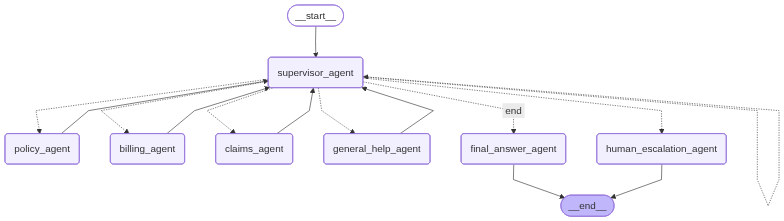

In [ ]:
@trace_agent
def supervisor_agent(state):
    print("---SUPERVISOR AGENT---")
    # Increment iteration counter
    n_iter = state.get("n_iteration", 0) + 1
    state["n_iteration"] = n_iter
    print(f"🔢 Supervisor iteration: {n_iter}")

    # Force end if iteration limit reached
    # Escalate to human support if iteration limit reached
    if n_iter >= 3:
        print("⚠️ Maximum supervisor iterations reached — escalating to human agent")
        updated_history = (
            state.get("conversation_history", "")
            + "\nAssistant: It seems this issue requires human review. Escalating to a human support specialist."
        )
        return {
            "escalate_to_human": True,
            "conversation_history": updated_history,
            "next_agent": "human_escalation_agent",
            "n_iteration": n_iter
        }
    
    # Check if we're coming from a clarification
    if state.get("needs_clarification", False):
        user_clarification = state.get("user_clarification", "")
        print(f"🔄 Processing user clarification: {user_clarification}")
        
        # Update conversation history with the clarification exchange
        clarification_question = state.get("clarification_question", "")
        updated_conversation = state.get("conversation_history", "") + f"\nAssistant: {clarification_question}\nUser: {user_clarification}"
        
        # Update state to clear clarification flags and update history
        updated_state = state.copy()
        updated_state["needs_clarification"] = False
        updated_state["conversation_history"] = updated_conversation
        
        # Clear clarification fields
        if "clarification_question" in updated_state:
            del updated_state["clarification_question"]
        if "user_clarification" in updated_state:
            del updated_state["user_clarification"]
            
        return updated_state

    user_query = state["user_input"]
    conversation_history = state.get("conversation_history", "")
    
    
    print(f"User Query: {user_query}")
    print(f"Conversation History: {conversation_history}")
    
    
    # Include the ENTIRE conversation history in the prompt
    full_context = f"Full Conversation:\n{conversation_history}"

    
    prompt = SUPERVISOR_PROMPT.format(
        conversation_history=full_context,  # Use full context instead of just history
    )

    tools = [
        {
            "type": "function",
            "function": {
                "name": "ask_user",
                "description": "Ask the user for clarification or additional information when their query is unclear or missing important details. ONLY use this if essential information like policy number or customer ID is missing.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "question": {
                            "type": "string",
                            "description": "The specific question to ask the user for clarification"
                        },
                        "missing_info": {
                            "type": "string", 
                            "description": "What specific information is missing or needs clarification"
                        }
                    },
                    "required": ["question", "missing_info"]
                }
            }
        }
    ]

    print("🤖 Calling LLM for supervisor decision...")
    response = client.chat.completions.create(
        model="gpt-5-mini",
        messages=[{"role": "system", "content": prompt}],
        tools=tools,
        tool_choice="auto"
    )

    message = response.choices[0].message

    # Check if supervisor wants to ask user for clarification
    if getattr(message, "tool_calls", None):
        print("🛠️ Supervisor requesting user clarification")
        for tool_call in message.tool_calls:
            if tool_call.function.name == "ask_user":
                args = json.loads(tool_call.function.arguments)
                question = args.get("question", "Can you please provide more details?")
                missing_info = args.get("missing_info", "additional information")
                
                print(f"❓ Asking user: {question}")
             
                
                user_response_data = ask_user(question, missing_info)
                user_response = user_response_data["context"]
                
                print(f"✅ User response: {user_response}")
                
                # Update conversation history with the question
                updated_history = conversation_history + f"\nAssistant: {question}"
                updated_history = updated_history + f"\nUser: {user_response}"
                
                return {
                    "needs_clarification": True,
                    "clarification_question": question,
                    "user_clarification": user_response,
                    "conversation_history": updated_history
                }

    # If no tool calls, proceed with normal supervisor decision
    message_content = message.content
    
    try:
        parsed = json.loads(message_content)
        print("✅ Supervisor output parsed successfully")
    except json.JSONDecodeError:
        print("❌ Supervisor output invalid JSON, using fallback")
        parsed = {}

    next_agent = parsed.get("next_agent", "general_help_agent")
    task = parsed.get("task", "Assist the user with their query.")
    justification = parsed.get("justification", "")

    print(f"---SUPERVISOR DECISION: {next_agent}---")
    print(f"Task: {task}")
    print(f"Reason: {justification}")

    # Update conversation history with the current exchange
    updated_conversation = conversation_history + f"\nAssistant: Routing to {next_agent} for: {task}"


    print(f"➡️ Routing to: {next_agent}")
    return {
        "next_agent": next_agent,
        "task": task,
        "justification": justification,
        "conversation_history": updated_conversation,
        "n_iteration": n_iter
    }

@trace_agent
def claims_agent_node(state):
    logger.info("🏥 Claims agent started")
    logger.debug(f"Claims agent state: { {k: v for k, v in state.items() if k != 'messages'} }")
    
    prompt = CLAIMS_AGENT_PROMPT.format(
        task=state.get("task"),
        policy_number=state.get("policy_number", "Not provided"),
        claim_id=state.get("claim_id", "Not provided"),
        conversation_history=state.get("conversation_history", "")
    )

    tools = [
        {"type": "function", "function": {
            "name": "get_claim_status",
            "description": "Retrieve claim details",
            "parameters": {"type": "object", "properties": {"claim_id": {"type": "string"}, "policy_number": {"type": "string"}}}
        }}
    ]

    result = run_llm(prompt, tools, {"get_claim_status": get_claim_status})
    
    logger.info("✅ Claims agent completed")
    return {"messages": [("assistant", result)]}

@trace_agent
def final_answer_agent(state):
    """Generate a clean final summary before ending the conversation"""
    print("---FINAL ANSWER AGENT---")
    logger.info("🎯 Final answer agent started")
    
    user_query = state["user_input"]
    conversation_history = state.get("conversation_history", "")
    
    # Extract the most recent specialist response
    recent_responses = []
    for msg in reversed(state.get("messages", [])):
        if hasattr(msg, 'content') and "clarification" not in msg.content.lower():
            recent_responses.append(msg.content)
            if len(recent_responses) >= 2:  # Get last 2 non-clarification responses
                break
    
    specialist_response = recent_responses[0] if recent_responses else "No response available"
    
    prompt = FINAL_ANSWER_PROMPT.format(

        specialist_response=specialist_response,  
        user_query=user_query,
    )
    
    print("🤖 Generating final summary...")
    response = client.chat.completions.create(
        model="gpt-5-mini",
        messages=[{"role": "system", "content": prompt}]
    )
    
    final_answer = response.choices[0].message.content
    
    print(f"✅ Final answer: {final_answer}")
    
    # Replace all previous messages with just the final answer
    clean_messages = [("assistant", final_answer)]

    state["final_answer"] = final_answer
    state["end_conversation"] = True
    state["conversation_history"] = conversation_history + f"\nAssistant: {final_answer}"
    state["messages"] = clean_messages
    
    return state


    
@trace_agent
def policy_agent_node(state):
    print("---POLICY AGENT---")
    logger.info("📄 Policy agent started")
    logger.debug(f"Policy agent state: { {k: v for k, v in state.items() if k != 'messages'} }")
    
    prompt = POLICY_AGENT_PROMPT.format(
        task=state.get("task"),
        policy_number=state.get("policy_number", "Not provided"),
        customer_id=state.get("customer_id", "Not provided"),
        conversation_history=state.get("conversation_history", "")
    )

    tools = [
        {"type": "function", "function": {
            "name": "get_policy_details",
            "description": "Fetch policy info by policy number",
            "parameters": {"type": "object", "properties": {"policy_number": {"type": "string"}}}
        }},
        {"type": "function", "function": {
            "name": "get_auto_policy_details",
            "description": "Get auto policy details",
            "parameters": {"type": "object", "properties": {"policy_number": {"type": "string"}}}
        }}
    ]

    print("🔄 Processing policy request...")
    result = run_llm(prompt, tools, {
        "get_policy_details": get_policy_details,
        "get_auto_policy_details": get_auto_policy_details
    })
    
    print("✅ Policy agent completed")
    return {"messages": [("assistant", result)]}

@trace_agent
def billing_agent_node(state):
    print("---BILLING AGENT---")
    print("TASK: ", state.get("task"))
    print("USER QUERY: ", state.get("user_input"))
    print("CONVERSATION HISTORY: ", state.get("conversation_history", ""))
    
    
    prompt = BILLING_AGENT_PROMPT.format(
        task=state.get("task"),
        conversation_history=state.get("conversation_history", "")
    )

    tools = [
        {"type": "function", "function": {
            "name": "get_billing_info",
            "description": "Retrieve billing information",
            "parameters": {"type": "object", "properties": {"policy_number": {"type": "string"}, "customer_id": {"type": "string"}}}
        }},
        {"type": "function", "function": {
            "name": "get_payment_history",
            "description": "Fetch recent payment history",
            "parameters": {"type": "object", "properties": {"policy_number": {"type": "string"}}}
        }}
    ]

    print("🔄 Processing billing request...")
    result = run_llm(prompt, tools, {
        "get_billing_info": get_billing_info,
        "get_payment_history": get_payment_history
    })
    
    print("✅ Billing agent completed")
    
    # Extract and preserve policy number if mentioned in the conversation
    updated_state = {"messages": [("assistant", result)]}
    
    # If we have a policy number in state, preserve it
    if state.get("policy_number"):
        updated_state["policy_number"] = state["policy_number"]
    if state.get("customer_id"):
        updated_state["customer_id"] = state["customer_id"]
        
    # Update conversation history
    current_history = state.get("conversation_history", "")
    updated_state["conversation_history"] = current_history + f"\nBilling Agent: {result}"
    
    return updated_state


@trace_agent
def general_help_agent_node(state):
    print("---GENERAL HELP AGENT---")

    user_query = state.get("user_input", "")
    conversation_history = state.get("conversation_history", "")
    task = state.get("task", "General insurance support")

    # Step 1: Retrieve relevant FAQs from the vector DB
    print("🔍 Retrieving FAQs...")
    logger.info("🔍 Retrieving FAQs from vector database")
    results = collection.query(
        query_texts=[user_query],
        n_results=3,
        include=["metadatas", "documents", "distances"]
    )

    # Step 2: Format retrieved FAQs
    faq_context = ""
    if results and results.get("metadatas") and results["metadatas"][0]:
        print(f"📚 Found {len(results['metadatas'][0])} relevant FAQs")
        for i, meta in enumerate(results["metadatas"][0]):
            q = meta.get("question", "")
            a = meta.get("answer", "")
            score = results["distances"][0][i]
            faq_context += f"FAQ {i+1} (score: {score:.3f})\nQ: {q}\nA: {a}\n\n"
    else:
        print("❌ No relevant FAQs found")
        faq_context = "No relevant FAQs were found."

    # Step 3: Format the final prompt
    prompt = GENERAL_HELP_PROMPT.format(
        task=task,
        conversation_history=conversation_history,
        faq_context=faq_context
    )

    print("🤖 Calling LLM for general response...")
    final_answer = run_llm(prompt)

    
    
    print("✅ General help agent completed")
    updated_state = {
                        "messages": [("assistant", final_answer)],
                        "retrieved_faqs": results.get("metadatas", []),
                    }


    updated_state["conversation_history"] = conversation_history + f"\nGeneral Help Agent: {final_answer}"

    return updated_state

@trace_agent
def human_escalation_node(state):
    print("---HUMAN ESCALATION AGENT---")
    logger.warning(f"Escalation triggered - State: { {k: v for k, v in state.items() if k != 'messages'} }")
    
    prompt = HUMAN_ESCALATION_PROMPT.format(
        task=state.get("task"),
        #user_query=state.get("user_input"),
        conversation_history=state.get("conversation_history", "")
    )

    print("🤖 Generating escalation response...")
    response = client.chat.completions.create(
        model="gpt-5-mini",
        messages=[{"role": "system", "content": prompt}]
    )

    print("🚨 Conversation escalated to human")
    return {
        "final_answer": response.choices[0].message.content,
        "requires_human_escalation": True,
        "escalation_reason": "Customer requested human assistance.",
        "messages": [("assistant", response.choices[0].message.content)]
    }



from langgraph.graph import StateGraph, END


from typing import TypedDict, List, Annotated, Dict, Any, Optional
from langgraph.graph import add_messages
from datetime import datetime

class GraphState(TypedDict):
    # Core conversation tracking
    messages: Annotated[List[Any], add_messages]
    user_input: str
    conversation_history: Optional[str]

    n_iteration: Optional[int]

    # Extracted context & metadata
    user_intent: Optional[str]            # e.g., "query_policy", "billing_issue"
    customer_id: Optional[str]
    policy_number: Optional[str]
    claim_id: Optional[str]
    
    # Supervisor / routing layer
    next_agent: Optional[str]             # e.g., "policy_agent", "claims_agent", etc.
    task: Optional[str]                   # Current task determined by supervisor
    justification: Optional[str]          # Supervisor reasoning/explanation
    end_conversation: Optional[bool]      # Flag for graceful conversation termination
    
    # Entity extraction and DB lookups
    extracted_entities: Dict[str, Any]    # Parsed from user input (dates, names, etc.)
    database_lookup_result: Dict[str, Any]
    
    # Escalation state
    requires_human_escalation: bool
    escalation_reason: Optional[str]
    
    # Billing-specific fields
    billing_amount: Optional[float]
    payment_method: Optional[str]
    billing_frequency: Optional[str]      # "monthly", "quarterly", "annual"
    invoice_date: Optional[str]
    
    # System-level metadata
    timestamp: Optional[str]     # Track time of latest user message or state update
    final_answer: Optional[str]


def decide_next_agent(state):
    # Handle clarification case first
    if state.get("needs_clarification"):
        return "supervisor_agent"  # Return to supervisor to process the clarification
    
    if state.get("end_conversation"):
        return "end"
    
    if state.get("requires_human_escalation"):
        return "human_escalation_agent"
    
    return state.get("next_agent", "general_help_agent")


# Update the workflow to include the final_answer_agent
workflow = StateGraph(GraphState)

workflow.add_node("supervisor_agent", supervisor_agent)
workflow.add_node("policy_agent", policy_agent_node)
workflow.add_node("billing_agent", billing_agent_node)
workflow.add_node("claims_agent", claims_agent_node)
workflow.add_node("general_help_agent", general_help_agent_node)
workflow.add_node("human_escalation_agent", human_escalation_node)
workflow.add_node("final_answer_agent", final_answer_agent)  # Add this

workflow.set_entry_point("supervisor_agent")



workflow.add_conditional_edges(
    "supervisor_agent",
    decide_next_agent,
    {
        "supervisor_agent": "supervisor_agent",
        "policy_agent": "policy_agent",
        "billing_agent": "billing_agent", 
        "claims_agent": "claims_agent",
        "human_escalation_agent": "human_escalation_agent",
        "general_help_agent": "general_help_agent",
        "end": "final_answer_agent"
    }
)

# Return to Supervisor after each specialist
for node in ["policy_agent", "billing_agent", "claims_agent", "general_help_agent"]:
    workflow.add_edge(node, "supervisor_agent")

# Final answer agent → END
workflow.add_edge("final_answer_agent", END)

# Human escalation → END
workflow.add_edge("human_escalation_agent", END)

app = workflow.compile()


# === Display the Graph ===
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


In [89]:

def run_test_query(query):
    """Test the system with a billing query"""
    initial_state = {
        "n_iteraton":0,
        "messages": [],
        "user_input": query,
        "user_intent": "",
        "claim_id": "",
        "next_agent": "supervisor_agent",
        "extracted_entities": {},
        "database_lookup_result": {},
        "requires_human_escalation": False,
        "escalation_reason": "",
        "billing_amount": None,
        "payment_method": None,
        "billing_frequency": None,
        "invoice_date": None,
        "conversation_history": f"User: {query}", 
        "task": "Help user with their query",
        "final_answer": ""
    }
    
    print(f"\n{'='*50}")
    print(f"QUERY: {query}")
    print(f"\n{'='*50}")
    
    # Run the graph
    final_state = app.invoke(initial_state)
    
    # Print the response
    print("\n---FINAL RESPONSE---")
    final_answer = final_state.get("final_answer", "No final answer generated.")
    print(final_answer)
    
    
    return final_state

In [72]:
# POL000004 , 
test_query = "What is the premium of my auto insurance policy?"
final_output =  run_test_query(test_query)


QUERY: What is the premium of my auto insurance policy?

---SUPERVISOR AGENT---
🔢 Supervisor iteration: 1
User Query: What is the premium of my auto insurance policy?
Conversation History: User: What is the premium of my auto insurance policy?
🤖 Calling LLM for supervisor decision...


2025-11-11 21:27:38,072 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 21:27:38,109 - __main__ - INFO - 🗣️ Asking user for input: Could you please provide your policy number?


🛠️ Supervisor requesting user clarification
❓ Asking user: Could you please provide your policy number?
---USER INPUT REQUIRED---
Missing information: policy number
✅ User response: POL000004
---SUPERVISOR AGENT---
🔢 Supervisor iteration: 1
User Query: What is the premium of my auto insurance policy?
Conversation History: User: What is the premium of my auto insurance policy?
Assistant: Could you please provide your policy number?
User: POL000004
🤖 Calling LLM for supervisor decision...


2025-11-11 21:27:47,218 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


✅ Supervisor output parsed successfully
---SUPERVISOR DECISION: billing_agent---
Task: Provide the premium for auto insurance policy POL000004.
Reason: User requested the premium for their auto insurance policy, and the policy number is available.
➡️ Routing to: billing_agent
---BILLING AGENT---
TASK:  Provide the premium for auto insurance policy POL000004.
USER QUERY:  What is the premium of my auto insurance policy?
CONVERSATION HISTORY:  User: What is the premium of my auto insurance policy?
Assistant: Could you please provide your policy number?
User: POL000004
Assistant: Routing to billing_agent for: Provide the premium for auto insurance policy POL000004.
🔄 Processing billing request...


2025-11-11 21:27:49,869 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 21:27:49,921 - __main__ - INFO - 🔍 Fetching billing info - Policy: POL000004, Customer: None
2025-11-11 21:27:49,986 - __main__ - INFO - ✅ Billing info found


Initial LLM Response: ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=[ChatCompletionMessageFunctionToolCall(id='call_XFUNAJa7AmZ074rCOkQrZDSC', function=Function(arguments='{"policy_number":"POL000004"}', name='get_billing_info'), type='function')])


2025-11-11 21:27:54,468 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


✅ Billing agent completed
---SUPERVISOR AGENT---
🔢 Supervisor iteration: 2
User Query: What is the premium of my auto insurance policy?
Conversation History: User: What is the premium of my auto insurance policy?
Assistant: Could you please provide your policy number?
User: POL000004
Assistant: Routing to billing_agent for: Provide the premium for auto insurance policy POL000004.
Billing Agent: The premium for policy POL000004 is $197.88.
🤖 Calling LLM for supervisor decision...


2025-11-11 21:27:56,250 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 21:27:56,264 - __main__ - INFO - 🎯 Final answer agent started


✅ Supervisor output parsed successfully
---SUPERVISOR DECISION: end---
Task: User asked for auto insurance premium information, which has been provided.
Reason: The user's question was fully answered regarding the auto insurance premium.
➡️ Routing to: end
---FINAL ANSWER AGENT---
🤖 Generating final summary...


2025-11-11 21:28:02,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 21:28:02,682 - __main__ - INFO - ✅ Final answer generated


✅ Final answer: Your auto insurance premium is $197.88. Thank you.

---FINAL RESPONSE---
Your auto insurance premium is $197.88. Thank you.


In [81]:
test_query = "In general, what does life insurance cover?"
final_output =  run_test_query(test_query)


QUERY: In general, what does life insurance cover?

---SUPERVISOR AGENT---
🔢 Supervisor iteration: 1
User Query: In general, what does life insurance cover?
Conversation History: User: In general, what does life insurance cover?
🤖 Calling LLM for supervisor decision...


2025-11-11 21:31:35,109 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 21:31:35,152 - __main__ - INFO - 🔍 Retrieving FAQs from vector database


✅ Supervisor output parsed successfully
---SUPERVISOR DECISION: general_help_agent---
Task: User asked about general coverage of life insurance.
Reason: User's question is general in nature and doesn't require specific policy details.
➡️ Routing to: general_help_agent
---GENERAL HELP AGENT---
🔍 Retrieving FAQs...
📚 Found 3 relevant FAQs
🤖 Calling LLM for general response...


2025-11-11 21:31:42,569 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Initial LLM Response: ChatCompletionMessage(content='In general, life insurance pays a money benefit to the person(s) you name (the beneficiary) if the insured person dies while the policy is in force. \n\nCommon points:\n- The death benefit can be used for things like funeral costs, paying off debts or a mortgage, replacing lost income, or funding college for dependents.  \n- Death is usually covered whether it’s from illness, injury, or “old age.”  \n- Many policies have a suicide exclusion during the first ~two years; after that suicide is often covered.  \n- If material fraud was used to get the policy, the insurer may void the policy and return only the premiums paid.\n\nThis is a general overview — exact coverage, exclusions, and waiting periods vary by policy and insurer. Would you like help with specific types of life insurance or what to ask an agent?', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None)
✅ General help agent complet

2025-11-11 21:31:44,261 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 21:31:44,314 - __main__ - INFO - 🎯 Final answer agent started


✅ Supervisor output parsed successfully
---SUPERVISOR DECISION: end---
Task: User received a general overview of life insurance coverage.
Reason: User's question was fully answered by the general_help_agent.
➡️ Routing to: end
---FINAL ANSWER AGENT---
🤖 Generating final summary...


2025-11-11 21:32:04,124 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 21:32:04,154 - __main__ - INFO - ✅ Final answer generated


✅ Final answer: In general, life insurance pays a sum of money to the people you name (beneficiaries) if the insured person dies while the policy is active. Beneficiaries often use that money for funeral costs, paying off debts or a mortgage, replacing lost income, or funding education. Exact coverage and any exclusions vary by policy, so check the policy details or ask an agent.  

If you’d like, I can help compare types of policies or estimate how much coverage you might need.

---FINAL RESPONSE---
In general, life insurance pays a sum of money to the people you name (beneficiaries) if the insured person dies while the policy is active. Beneficiaries often use that money for funeral costs, paying off debts or a mortgage, replacing lost income, or funding education. Exact coverage and any exclusions vary by policy, so check the policy details or ask an agent.  

If you’d like, I can help compare types of policies or estimate how much coverage you might need.


In [90]:
test_query = "I want to talk to human executive"
final_output =  run_test_query(test_query)


QUERY: I want to talk to human executive

---SUPERVISOR AGENT---
🔢 Supervisor iteration: 1
User Query: I want to talk to human executive
Conversation History: User: I want to talk to human executive
🤖 Calling LLM for supervisor decision...


2025-11-11 21:38:22,855 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-11 21:38:22,890 - __main__ - WARNING - Escalation triggered - State: {'user_input': 'I want to talk to human executive', 'conversation_history': 'User: I want to talk to human executive\nAssistant: Routing to human_escalation_agent for: User requested to speak with a human executive.', 'n_iteration': 1, 'user_intent': '', 'claim_id': '', 'next_agent': 'human_escalation_agent', 'task': 'User requested to speak with a human executive.', 'justification': 'User explicitly asked to talk to a human executive.', 'extracted_entities': {}, 'database_lookup_result': {}, 'requires_human_escalation': False, 'escalation_reason': '', 'billing_amount': None, 'payment_method': None, 'billing_frequency': None, 'invoice_date': None, 'final_answer': ''}


✅ Supervisor output parsed successfully
---SUPERVISOR DECISION: human_escalation_agent---
Task: User requested to speak with a human executive.
Reason: User explicitly asked to talk to a human executive.
➡️ Routing to: human_escalation_agent
---HUMAN ESCALATION AGENT---
🤖 Generating escalation response...


2025-11-11 21:38:26,449 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


🚨 Conversation escalated to human

---FINAL RESPONSE---
I’m sorry you’re experiencing this and I understand you want to speak with a human executive. A human representative will join shortly to assist you. Thank you for your patience.
